In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import random
import os
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
import lifelines.statistics
 
sns.set_theme()
sns.set_context("notebook")
sns.set_palette("colorblind")

# DP - Mechanism Definitions

In [2]:
# check if the possible epsilon is negative
def verify_epsilon(p,n):
    epsilon = np.log((n*p+1-p)/(n-1-n*p+p))
    if epsilon <= 0:
        print('epsilon is negative for such values of p and n')
        return None
    else:
        return epsilon

In [3]:
def revised_coin_toss(category, list_of_cathegories, n, p):
    cathegories = list_of_cathegories
    '''
    category: IPSS-R category, value to be privatized
    list_of_uniques: list of unique cathegories
    n: number of categories (not used in this function, used to compute the epsilon)
    p: coin bias
    '''    
    # compute epsilon
    epsilon = verify_epsilon(p,n)

    # toss a coin H with probability p, T with probability 1-p
    coin = np.random.choice(['H', 'T'], p=[p, 1-p])

    # if coin is H, return the original value
    if coin == 'H':
        return category
    
    # if coin is T, return a random value from the n categories
    else:
        #remove the category from the list of unique values
        list_of_cathegories = np.delete(cathegories, np.where(list_of_cathegories == category))
        #return a random value from the list of unique values
        return random.choice(list_of_cathegories)


# Bernard et al.

In [4]:
#define path to data
data_path = "../data/"
bernard = "BernardEtAl/"

#read the data
path_verylow = data_path+bernard+'veryLow.tsv'
df_verylow = pd.read_csv(path_verylow, sep='\t')
path_low = data_path+bernard+'low.tsv'
df_low = pd.read_csv(path_low, sep='\t')
path_int = data_path+bernard+'int.tsv'
df_int = pd.read_csv(path_int, sep='\t')
path_high = data_path+bernard+'high.tsv'
df_high = pd.read_csv(path_high, sep='\t')
path_veryhigh = data_path+bernard+'veryHigh.tsv'
df_veryhigh = pd.read_csv(path_veryhigh, sep='\t')

# Add a column with the risk group to each of the dataframes
df_verylow['Risk Group'] = 'Very Low'
df_low['Risk Group'] = 'Low'
df_int['Risk Group'] = 'Intermediate'
df_high['Risk Group'] = 'High'
df_veryhigh['Risk Group'] = 'Very High'

# Concatenate the dataframes
df = pd.concat([df_verylow, df_low, df_int, df_high, df_veryhigh]).reset_index(drop=True)

df['Status'] = df['Status'].map({'censored': 0, 'deceased': 1})
#eliminate columns
df = df.drop(['Case ID', 'Study ID', 'Survival Rate', 'Number at Risk'], axis=1)
#raname columns
df = df.rename(columns={'Time (months)': 'Time'})

df

,Status,Time,Risk Group
0,0,0.000000,Very Low
1,0,0.000000,Very Low
2,0,0.000000,Very Low
3,0,0.000000,Very Low
4,0,0.000000,Very Low
...,...,...,...
2995,0,77.786301,Very High
2996,1,79.923288,Very High
2997,0,97.380822,Very High
2998,0,129.665753,Very High


## Macro Survival Analysis

## Group Survival Analysis

In [5]:
#get unique risks groups
risk_groups = df['Risk Group'].unique()
risk_groups

array(['Very Low', 'Low', 'Intermediate', 'High', 'Very High'],
      dtype=object)

In [6]:
# set the coin bias
p_1 = 0.8
n = len(risk_groups)
e1 = verify_epsilon(p_1, n)
# privatize the IPSS-R category
df['Privatized Cancer Group'] = df['Risk Group'].apply(lambda x: revised_coin_toss(x, risk_groups, n, p_1))

In [7]:
df

,Status,Time,Risk Group,Privatized Cancer Group
0,0,0.000000,Very Low,Very Low
1,0,0.000000,Very Low,High
2,0,0.000000,Very Low,Very Low
3,0,0.000000,Very Low,Very Low
4,0,0.000000,Very Low,Very Low
...,...,...,...,...
2995,0,77.786301,Very High,Very High
2996,1,79.923288,Very High,Very High
2997,0,97.380822,Very High,Very High
2998,0,129.665753,Very High,Very High


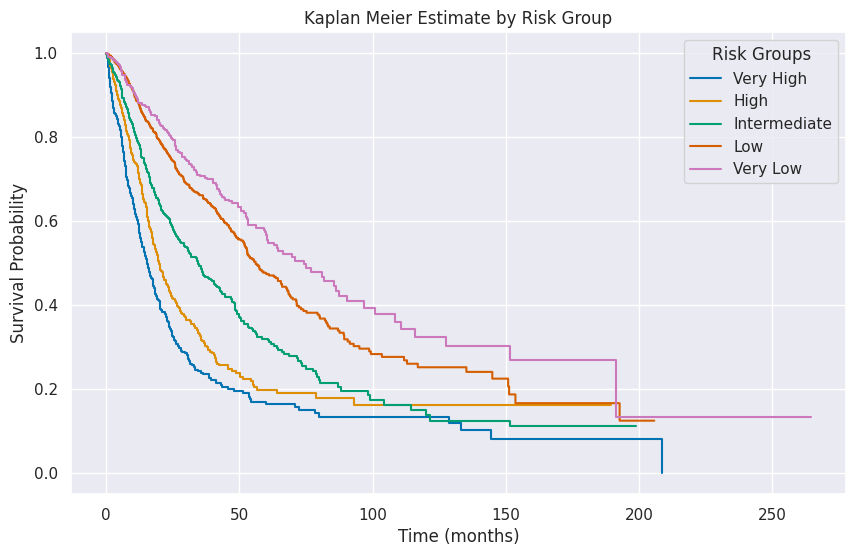

In [8]:
groups = df['Privatized Cancer Group']
ix_vl = (groups == 'Very Low')
ix_l = (groups == 'Low')
ix_i = (groups == 'Intermediate')
ix_h = (groups == 'High')
ix_vh = (groups == 'Very High')

km = KaplanMeierFitter()

plt.figure(figsize=(10, 6))  # Setting the figure size

# Fitting and plotting for each risk group
medians = []
medians_ci = []
for ix, label in zip([ix_vh, ix_h, ix_i, ix_l, ix_vl], ['Very High', 'High', 'Intermediate', 'Low', 'Very Low']):
    km.fit(df['Time'][ix], df['Status'][ix], label=label)
    medians.append(km.median_survival_time_)
    medians_ci.append(median_survival_times(km.confidence_interval_))
    km.plot(ax=plt.gca(), ci_show=False)  # Use the current axes, overlaying the plots

plt.title('Kaplan Meier Estimate by Risk Group')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.legend(title='Risk Groups', loc = 'best')

plt.show()

In [9]:
results = lifelines.statistics.pairwise_logrank_test(df['Time'], df['Risk Group'], df['Status'])

In [10]:
results_dp = lifelines.statistics.pairwise_logrank_test(df['Time'], df['Privatized Cancer Group'], df['Status'])

In [11]:
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                           test_statistic      p  -log2(p)
High         Intermediate           57.64 <0.005     44.85
             Low                   232.61 <0.005    172.05
             Very High              34.13 <0.005     27.53
             Very Low              244.19 <0.005    180.44
Intermediate Low                    42.25 <0.005     33.54
             Very High             180.06 <0.005    133.96
             Very Low               82.76 <0.005     63.23
Low          Very High             485.68 <0.005    355.13
             Very Low               20.90 <0.005     17.66
Very High    Very Low              413.68 <0.005    303.08

In [12]:
results_dp.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                           test_statistic      p  -log2(p)
High         Intermediate           19.85 <0.005     16.87
             Low                   125.80 <0.005     94.57
             Very High               9.81 <0.005      9.17
             Very Low              130.71 <0.005     98.14
Intermediate Low                    42.04 <0.005     33.38
             Very High              52.18 <0.005     40.85
             Very Low               59.24 <0.005     46.03
Low          Very High             194.90 <0.005    144.73
             Very Low                6.33   0.01      6.39
Very High    Very Low              185.38 <0.005    137.83

In [13]:
for median, ci in zip(medians, medians_ci):
    print('Median survival time:', "{:.2f}".format(median))
    print(ci)

Median survival time: 15.45
     Very High_lower_0.95  Very High_upper_0.95
0.5             13.150685             17.720548
Median survival time: 19.92
     High_lower_0.95  High_upper_0.95
0.5        17.654795        22.454795
Median survival time: 34.62
     Intermediate_lower_0.95  Intermediate_upper_0.95
0.5                 29.09589                40.405479
Median survival time: 56.12
     Low_lower_0.95  Low_upper_0.95
0.5       52.010959       65.589041
Median survival time: 74.27
     Very Low_lower_0.95  Very Low_upper_0.95
0.5            60.526027            87.452055


In [28]:
results.summary

test_statistic              p    -log2(p)
High         Intermediate       57.638597   3.149837e-14   44.851716
             Low               232.608992   1.608342e-52  172.054686
             Very High          34.133067   5.146916e-09   27.533645
             Very Low          244.186335   4.807615e-55  180.440724
Intermediate Low                42.250941   8.028138e-11   33.536144
             Very High         180.056735   4.710129e-41  133.963285
             Very Low           82.764052   9.245619e-20   63.229792
Low          Very High         485.678766  1.241858e-107  355.133806
             Very Low           20.898514   4.842702e-06   17.655756
Very High    Very Low          413.681631   5.790799e-92  303.083622

In [30]:
#save test_statistic and p-values in a dataframe
results_df = pd.DataFrame(results.summary)
results_df['run'] = '1'

results_df

test_statistic              p    -log2(p) run
High         Intermediate       57.638597   3.149837e-14   44.851716   1
             Low               232.608992   1.608342e-52  172.054686   1
             Very High          34.133067   5.146916e-09   27.533645   1
             Very Low          244.186335   4.807615e-55  180.440724   1
Intermediate Low                42.250941   8.028138e-11   33.536144   1
             Very High         180.056735   4.710129e-41  133.963285   1
             Very Low           82.764052   9.245619e-20   63.229792   1
Low          Very High         485.678766  1.241858e-107  355.133806   1
             Very Low           20.898514   4.842702e-06   17.655756   1
Very High    Very Low          413.681631   5.790799e-92  303.083622   1